In [38]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from tiny_ta import atr, rsi, sma

# End of the Month - Strategie im SDAX

Zunächst werden die Kursdaten geladen und bereinigt

In [39]:
sdax = pd.read_csv(
    "sdax.csv",
    decimal=",",
    thousands=".",
    date_format="%d.%m.%Y",
    parse_dates=["Datum"],
).set_index("Datum")

sdax.rename(
    {
        "Zuletzt": "Close",
        "Eröffn.": "Open",
        "Hoch": "High",
        "Tief": "Low",
        "Vol.": "Volume",
    },
    inplace=True,
    axis=1,
)

stock = sdax.sort_index(ascending=True)[["Open", "High", "Low", "Close"]]
stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

Ein paar Indikatoren werden für spätere Auswertungen mit hinzugefügt

In [40]:
stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["month"] = stock.index.month

Markiere die letzten x Tage und ersten x Tage im Monat für die geplanten Trades. 

In [41]:
days = 5

# Identify end of month
end_of_month = stock.groupby([stock.index.year, stock.index.month]).tail(days)

# Identify beginning of month
beginning_of_month = stock.groupby([stock.index.year, stock.index.month]).head(days)

# Combine the results
marked_days = pd.concat([end_of_month, beginning_of_month])
marked_days["hold"] = 1

df = pd.merge(
    left=stock,
    right=marked_days[["hold"]],
    left_index=True,
    right_index=True,
    how="left",
)

df.hold = df.hold.fillna(0)

df["buy"] = np.where(
    (df.hold.shift(1) == 0) & (df.hold == 1),
    1,
    np.where((df.hold == 1) & (df.hold.shift(-1) == 0), -1, np.nan),
)

df.hold = np.where(df.hold == 1, df.Low, np.nan)

In [42]:
from backtesting import Strategy


class end_of_month(Strategy):
    """
    strategy for trend_trading
    """

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

        # long signal
        self.hold = self.I(
            lambda: self.data.hold,
            overlay=True,
            name="Hold",
            scatter=True,
            color="green",
        )

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.buy[-1] == -1:
                    trade.close()

        # ORDER_SIZE = 0.5

        if self.data.buy[-1] == 1:
            self.buy()

In [43]:
from backtesting import Backtest

bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run()
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='5656', ...)

In [44]:
stats

Start                     2012-01-02 00:00:00
End                       2024-04-15 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   47.349823
Equity Final [$]                 186541.99894
Equity Peak [$]                  189228.31894
Return [%]                          86.541999
Buy & Hold Return [%]              221.032972
Return (Ann.) [%]                    5.176714
Volatility (Ann.) [%]                11.30857
Sharpe Ratio                         0.457769
Sortino Ratio                        0.679219
Calmar Ratio                         0.285167
Max. Drawdown [%]                  -18.153261
Avg. Drawdown [%]                   -2.425342
Max. Drawdown Duration      859 days 00:00:00
Avg. Drawdown Duration       69 days 00:00:00
# Trades                                  147
Win Rate [%]                        61.904762
Best Trade [%]                       8.210903
Worst Trade [%]                    -15.898519
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [45]:
stats["Win Rate [%]"]

61.904761904761905

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [46]:
stats["Avg. Trade [%]"]

0.43128643845800063

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [47]:
stats["Profit Factor"]

1.4758268853932452

In [48]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [49]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.06].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.2282
2,0.0586
3,-0.3021
4,0.1841
5,0.0330
6,0.1315
7,0.0733
8,0.0487
9,0.0335


<Axes: title={'center': 'Gewinner Trades'}>

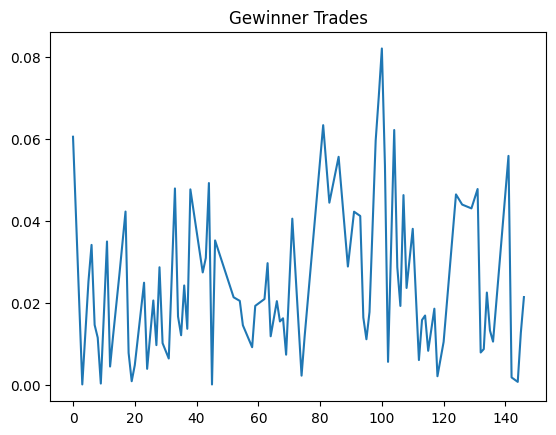

In [50]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

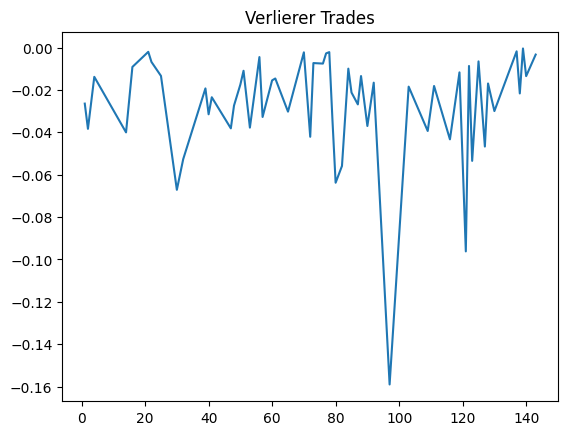

In [51]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [52]:
class end_of_month_and_skip_month(end_of_month):
    """
    strategy for trend_trading
    """

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.buy[-1] == -1:
                    trade.close()

        # ORDER_SIZE = 0.5

        if self.data.buy[-1] == 1 and self.data.month[-1] not in skip_month:
            self.buy()

In [53]:
bt = Backtest(
    df["2012-01-01":], end_of_month_and_skip_month, cash=100_000, commission=0.002
)
stats = bt.run()
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='6706', ...)

In [54]:
stats

Start                     2012-01-02 00:00:00
End                       2024-04-15 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   19.723739
Equity Final [$]                  227928.8562
Equity Peak [$]                   231028.4562
Return [%]                         127.928856
Buy & Hold Return [%]              221.032972
Return (Ann.) [%]                    6.896666
Volatility (Ann.) [%]                7.462157
Sharpe Ratio                         0.924219
Sortino Ratio                        1.521566
Calmar Ratio                          0.44295
Max. Drawdown [%]                  -15.569856
Avg. Drawdown [%]                   -1.617843
Max. Drawdown Duration     1407 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                   61
Win Rate [%]                        67.213115
Best Trade [%]                       8.210903
Worst Trade [%]                     -4.002143
Avg. Trade [%]                    

In [55]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)

In [56]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.2282
4,0.1841
6,0.1315
7,0.0733
11,0.2716
